In [29]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from method.mola.mola import get_mola
from pyresample import geometry, kd_tree
from method.sharad_sim.sharad_rdr_data import get_sharad_rdr_data
from method.geological_units.get_geological_units import get_units
from method.attributes_database.hirise_to_db import get_corL_rmsH
from method.attributes_database.perimittivity_to_db import get_permittivity
from pathlib import Path
import json
import simmulation as sm

In [30]:
PRODUCT_ID = "S_00170101"

In [31]:
# 创建文件夹
result_path = str(sm.BASE_DIR / "data" / "result" / PRODUCT_ID)
if not os.path.exists(result_path):
    os.makedirs(result_path)

In [32]:
geom_data = np.load(result_path + "/geom_data.npy", allow_pickle=True)
rgram_data = np.load(result_path + "/rgram_data.npy", allow_pickle=True)
sim_area_lonlat = np.load(result_path + "/sim_area_lonlat.npy", allow_pickle=True)
sat_lon_lat = np.load(result_path + "/sat_lon_lat.npy", allow_pickle=True)
point_count = np.load(result_path + "/point_count.npy", allow_pickle=True)
sat_radius = np.load(result_path + "/sat_radius.npy", allow_pickle=True)
sim_area_cartesian = np.load(result_path + "/sim_area_cartesian.npy", allow_pickle=True)
facet_index = np.load(result_path + "/facet_index.npy", allow_pickle=True)
center_point = np.load(result_path + "/center_point.npy", allow_pickle=True)
normal_vector = np.load(result_path + "/normal_vector.npy", allow_pickle=True)
area = np.load(result_path + "/area.npy", allow_pickle=True)
corL = np.load(result_path + "/corL.npy", allow_pickle=True)
rmsH = np.load(result_path + "/rmsH.npy", allow_pickle=True)
permittivity = np.load(result_path + "/permittivity.npy", allow_pickle=True)
incident_angle = np.load(result_path + "/incident_angle.npy", allow_pickle=True)
delay = np.load(result_path + "/delay.npy", allow_pickle=True)
distance = np.load(result_path + "/distance.npy", allow_pickle=True)
sgm_hh = np.load(result_path + "/sgm_hh.npy", allow_pickle=True)
sgm_vv = np.load(result_path + "/sgm_vv.npy", allow_pickle=True)
delay_index = np.load(result_path + "/delay_index.npy", allow_pickle=True)
rgram_hh = np.load(result_path + "/rgram_hh.npy", allow_pickle=True)
rgram_vv = np.load(result_path + "/rgram_vv.npy", allow_pickle=True)

In [33]:
mars_radius = 3396190
velocity_light = 299792458
sharad_freq = 20e6
delay_interval = 0.0375 * 1e-6  # 0.075 microseconds
k = 2 * np.pi * velocity_light / sharad_freq

In [34]:
k1 = k * np.sqrt(permittivity)
sat_pos = sm.lonlat_to_cartesian(sat_lon_lat, sat_radius).T
# sat_pos扩展为(center_point.shape[0], center_point.shape[1]),在axis =1上复制值
sat_pos = np.tile(sat_pos, (center_point.shape[1], 1, 1)).transpose((1, 0, 2))
sat_pos = sat_pos.reshape((center_point.shape[0] * center_point.shape[1], 3))
shape = center_point.shape
_center_point = center_point.reshape(
    (center_point.shape[0] * center_point.shape[1], 3)
)
ki = _center_point - sat_pos
# 归一化
ki = ki / np.linalg.norm(ki, axis=1)[:, None]

In [35]:
# Rh = (k*cos_theta_i - sqrt(k1^2-k^2*sin_theta_i.^2))./ (k*cos_theta_i + sqrt(k1^2-k^2*sin_theta_i.^2));
cos_theta_i = np.cos(incident_angle)
sin_theta_i = np.sin(incident_angle)
Rh = ( k * cos_theta_i - np.sqrt( k1**2 - k**2 * sin_theta_i**2 ) ) / ( k * cos_theta_i + np.sqrt( k1**2 - k**2 * sin_theta_i**2 ) )
# Rv = (epsilon_r*k*cos_theta_i - sqrt(k1^2-k^2*sin_theta_i.^2))./ (epsilon_r*k*cos_theta_i + sqrt(k1^2-k^2*sin_theta_i.^2));
Rv = ( permittivity * k * cos_theta_i - np.sqrt( k1**2 - k**2 * sin_theta_i**2 ) ) / ( permittivity * k * cos_theta_i + np.sqrt( k1**2 - k**2 * sin_theta_i**2 ) )
print(Rh.shape, Rv.shape)

(1928, 12000) (1928, 12000)


In [36]:
# hi = cross(ki,normal,2);
normal_vector = normal_vector.reshape((normal_vector.shape[0] * normal_vector.shape[1], 3))
hi = np.cross(ki, normal_vector, axis=1)
# hi = hi/norm(hi);
hi = hi / np.linalg.norm(hi, axis=1)[:, None]
# vi = cross(hi,ki,2);
vi = np.cross(hi, ki, axis=1)
print(hi.shape, vi.shape)

(23136000, 3) (23136000, 3)


In [37]:
Ei = 1
E = Ei * np.ones([hi.shape[0],3])
E = E / np.linalg.norm(E, axis=1)[:, None]

In [38]:
# F = -dot(E,hi,2).*dot(normal,ki,2).*(1-Rh).*hi +...
#     dot(E,vi,2).*cross(normal,hi,2).*(1+Rv) +...
#     dot(E,hi,2).*cross(-ki,cross(normal,hi,2),2).*(1+Rh) +...
#     dot(E,vi,2).*dot(normal,ki,2).*cross(-ki,hi,2).*(1-Rv);
# IA = exp(-2j*k*R.');
# Es = (1j*k*F)./(4*pi*R.').^2 .* IA .*area;
Rh = Rh.reshape((Rh.shape[0] * Rh.shape[1], 1))
Rv = Rv.reshape((Rv.shape[0] * Rv.shape[1], 1))
# 计算各个部分的点乘和叉乘  
F1 = -np.sum(E * hi, axis=1)[:, np.newaxis] * np.sum(normal_vector * ki, axis=1)[:, np.newaxis] * (1 - Rh) * hi  
F2 = np.sum(E * vi, axis=1)[:, np.newaxis] * np.cross(normal_vector, hi,axis =1) * (1 + Rv)  
F3 = np.sum(E * hi, axis=1)[:, np.newaxis] * np.cross(-ki, np.cross(normal_vector, hi,axis =1),axis =1) * (1 + Rh)  
F4 = np.sum(E * vi, axis=1)[:, np.newaxis] * np.sum(normal_vector * ki, axis=1)[:, np.newaxis] * np.cross(-ki, hi,axis =1) * (1 - Rv)  
  
# 合并得到F  
F = F1 + F2 + F3 + F4

distance = distance.reshape((distance.shape[0] * distance.shape[1], 1))
area = area.reshape((area.shape[0] * area.shape[1], 1))
IA = np.exp(-2j * k * distance)
Es = (1j * k * F) / (4 * np.pi * distance)**2 * IA * area



MemoryError: Unable to allocate 177. MiB for an array with shape (23136000,) and data type float64

In [22]:
Es_sum = np.zeros((3600, point_count,3), dtype=complex)
Es = Es.reshape((delay.shape[0], delay.shape[1],3))
for i in range(delay.shape[0]):
    # 使用delay[i]作为索引，将sgm_hh[i]的值加到img的相应位置
    np.add.at(Es_sum[:, i], delay_index[i], Es[i])

MemoryError: Unable to allocate 318. MiB for an array with shape (3600, 1928, 3) and data type complex128

In [23]:
# 计算幅度谱
Es_sum_a = Es_sum.reshape((3600*point_count , 3))
# E=sqrt(abs(E_sumhh(:,1)).^2+abs(E_sumhh(:,2)).^2+abs(E_sumhh(:,3)).^2);
Es_sum_a = np.sqrt(abs(Es_sum_a[:, 0])**2 + abs(Es_sum_a[:, 1])**2 + abs(Es_sum_a[:, 2])**2)
Es_sum_a = Es_sum_a.reshape((3600, point_count))

NameError: name 'Es_sum' is not defined

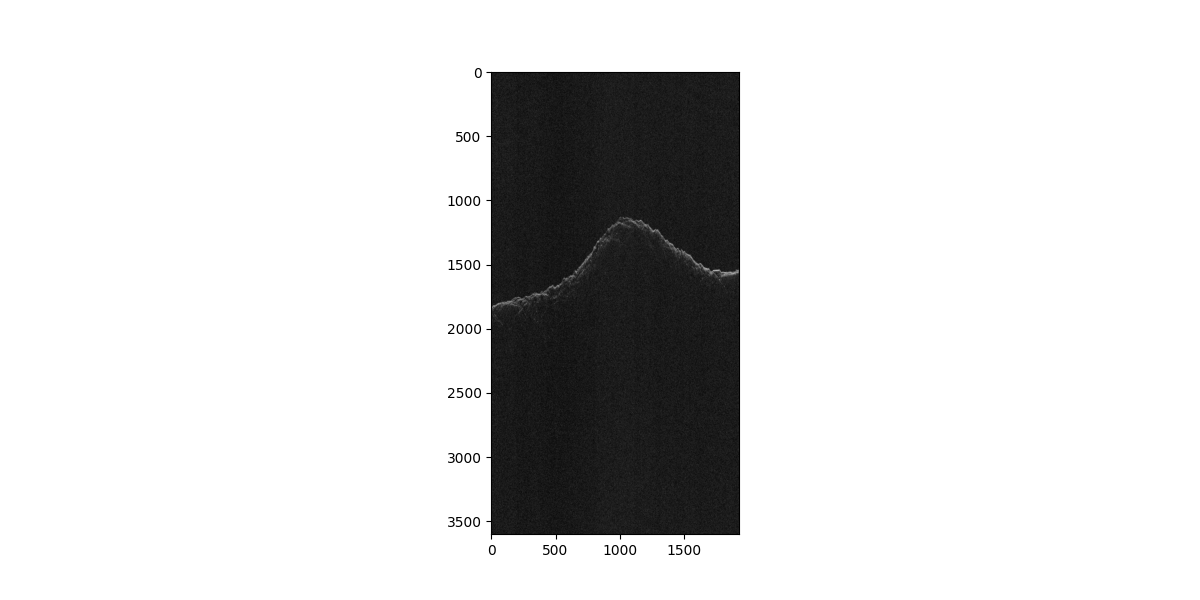

In [43]:
def process_img_for_plot(img):
    # log处理
    imgScale = np.log10(img + 1e-30)
    # 获取实际的值
    imgValid = imgScale[img != 0]
    # 使图像分布在0-255
    p10 = np.percentile(imgValid, 10)
    m = 255 / (imgValid.max() - p10)
    b = -p10 * m
    # 去除最小值
    img = imgScale * m + b
    img[img < 0] = 0
    return img
figure = plt.figure(figsize=(12, 6))
plt.imshow(process_img_for_plot(rgram_data), cmap='gray')
plt.show()

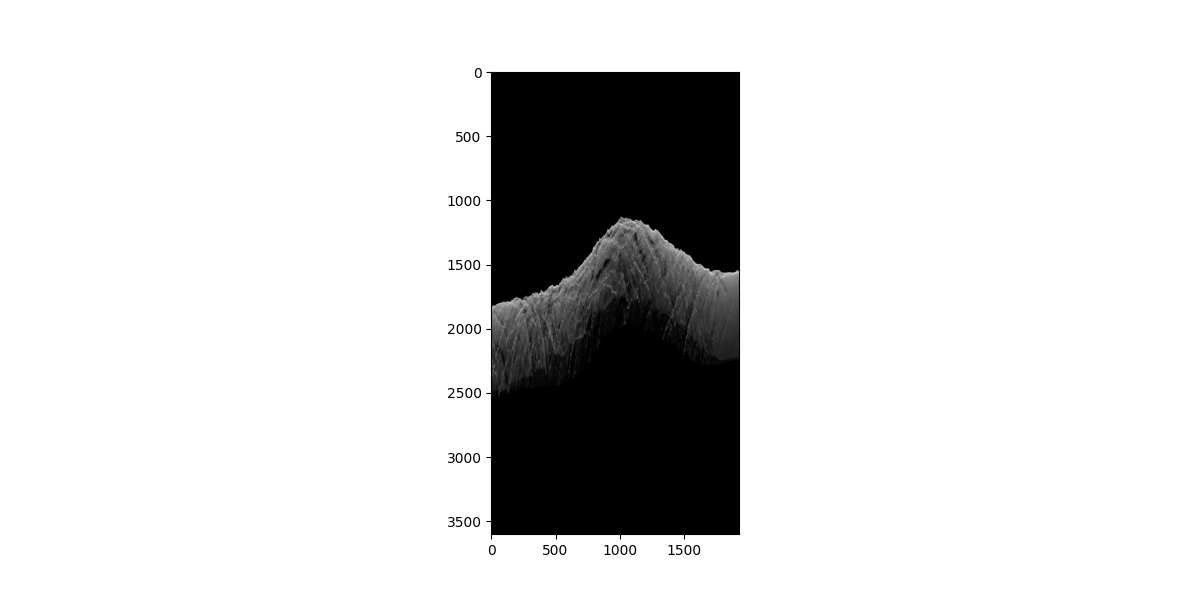

In [46]:
figure2 = plt.figure(figsize=(12, 6))
plt.imshow(process_img_for_plot(rgram_vv), cmap='gray')
plt.show()

In [26]:
plt.imshow(Es_sum_a, cmap='gray')
plt.show()

NameError: name 'Es_sum_a' is not defined

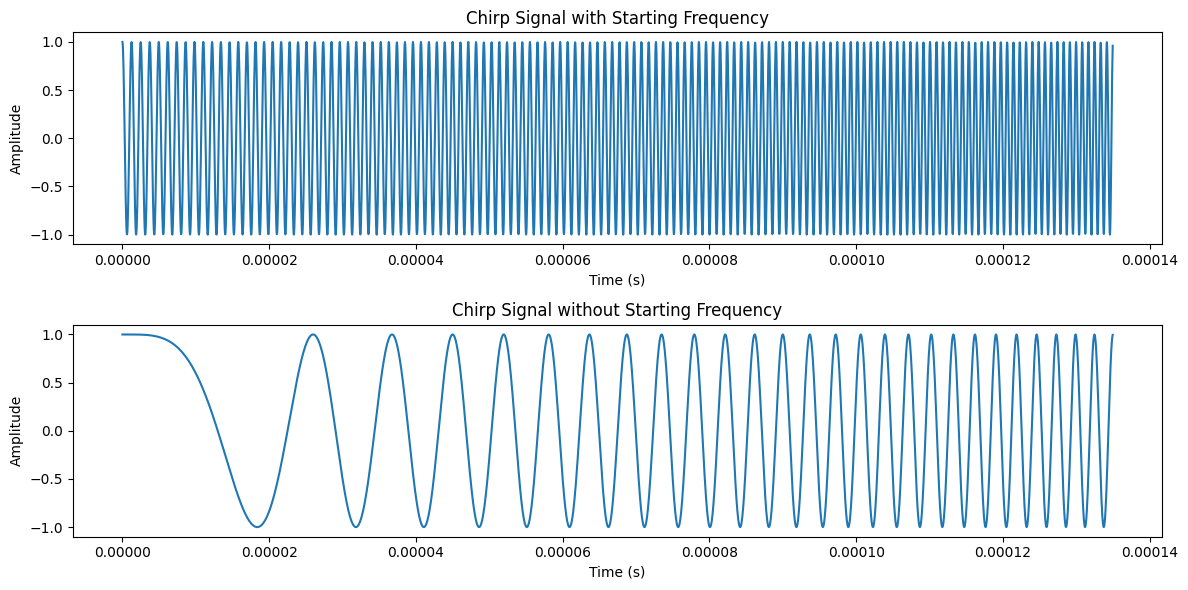

In [136]:
import numpy as np  
from scipy.signal import chirp  
import matplotlib.pyplot as plt  

temp_freq = 1e6
freq_width = 0.4e6

# 定义信号参数  
T = 0.000135            # 信号总时长  
fs = 1/0.0375*1e6         # 采样频率  
t = np.linspace(0, T, int(fs * T), endpoint=False)  # 时间数组  
f0 = temp_freq - freq_width          # 起始频率（Hz）  
f1 = temp_freq + freq_width         # 终止频率（Hz）  
method = 'linear'  # 扫频方法，可以是 'linear', 'quadratic', 'logarithmic' 等  
  
# 生成加载频的chirp信号（起始频率不为0）  
chirp_signal = chirp(t, f0=f0, f1=f1, t1=T, method=method)  
  
# 生成不加载频的chirp信号（起始频率为0）  
chirp_signal_no_f0 = chirp(t, f0=0, f1=f1-f0, t1=T, method=method)  
  
# 绘制信号  
plt.figure(figsize=(12, 6))  
  
plt.subplot(2, 1, 1)  
plt.title('Chirp Signal with Starting Frequency')  
plt.plot(t, chirp_signal)  
plt.xlabel('Time (s)')  
plt.ylabel('Amplitude')  
  
plt.subplot(2, 1, 2)  
plt.title('Chirp Signal without Starting Frequency')  
plt.plot(t, chirp_signal_no_f0)  
plt.xlabel('Time (s)')  
plt.ylabel('Amplitude')  
  
plt.tight_layout()  
plt.show()

In [137]:
Ei = 1 * np.ones([Es_sum.shape[0] * Es_sum.shape[1],3])
temp = Es_sum.reshape((Es_sum.shape[0] * Es_sum.shape[1], 3))
summ = np.sum(temp * Ei, axis=1)[:, np.newaxis]

In [138]:
import scipy.fft as fft

summ = summ.reshape((Es_sum.shape[0], Es_sum.shape[1]))
E_sum = fft.fft(summ,axis = 1)
chirp_sig = fft.fft(chirp_signal)
E_summ = E_sum * chirp_sig[:, np.newaxis]
E_summ = fft.ifft(E_summ,axis = 1)

In [139]:
E_sum_ji = E_summ * np.exp(1j * np.pi * 2 * sharad_freq * t)[:, np.newaxis]

In [140]:
# E_summ=ifft(fft(E_sum_ji).*conj(fft(chrip2)));
E_summ_final = fft.ifft(fft.fft(E_summ,axis = 1) * np.conj(fft.fft(chirp_signal_no_f0)[:, np.newaxis]),axis = 1)

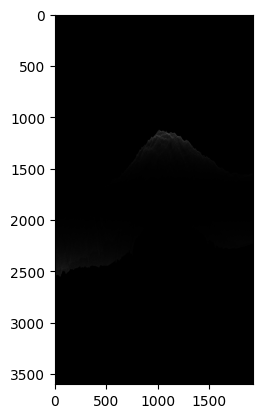

In [141]:
plt.imshow(np.abs(E_summ_final), cmap='gray')
plt.savefig('E_summ.png')

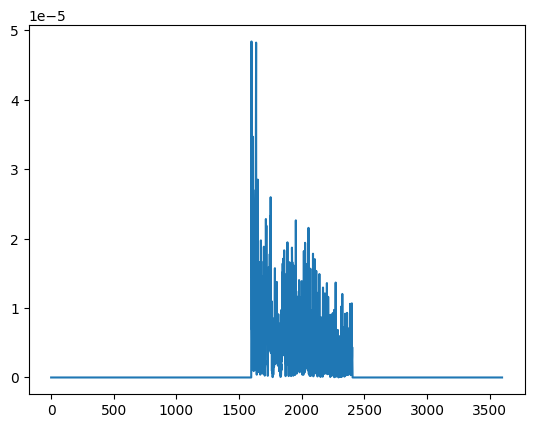

In [43]:
plt.plot(np.abs(E_summ[:, 600]))
plt.show()

Horizontal Response: [0.         0.8660254  1.22474487]
Vertical Response: [0.00000000e+00 6.12372436e-01 7.49939943e-17]


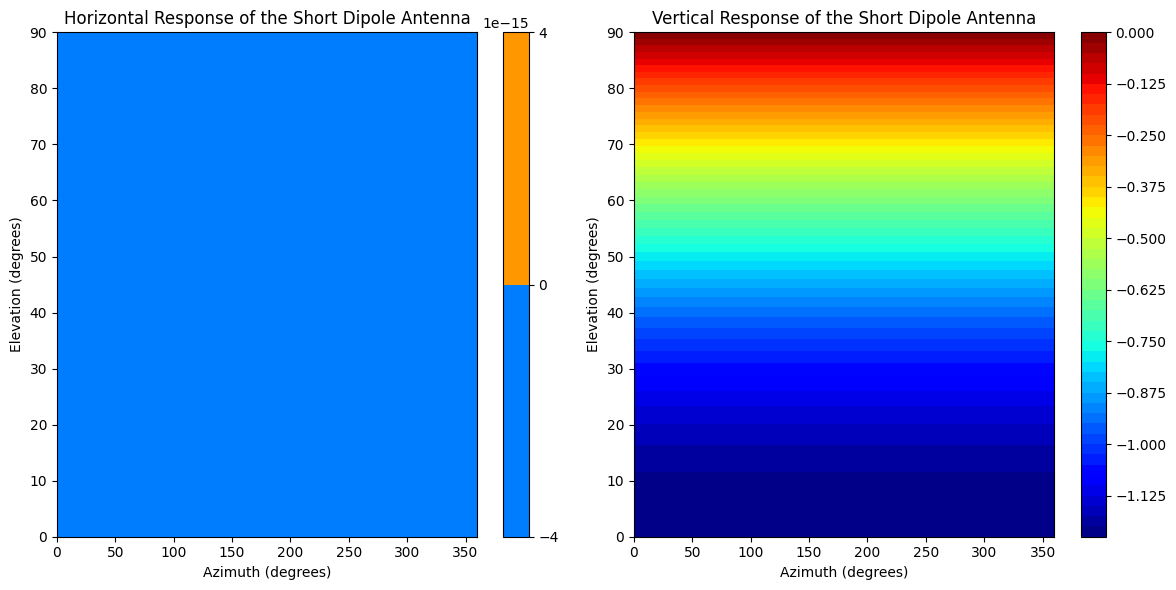

In [92]:
import numpy as np  
  
def shortdipole(pax, ang):  
    """  
    计算短偶极子天线的水平和垂直响应。  
      
    参数:  
        pax (np.array): 3x1 向量，表示偶极子天线在 X, Y, Z 方向上的极化或幅度。  
        ang (np.array): 2xN 矩阵，其中 ang[0, :] 是方位角，ang[1, :] 是仰角。  
          
    返回:  
        resp (dict): 包含 'H' 和 'V' 键的字典，分别对应水平和垂直响应。  
    """  
    # 确保输入是 NumPy 数组  
    pax = np.asarray(pax)  
    ang = np.asarray(ang)  
      
    # 初始化响应字典  
    resp = {}  
      
    # 计算水平响应  
    resp['H'] = (pax[0] * get_short_dipole_h_response(ang, 'X') +  
                 pax[1] * get_short_dipole_h_response(ang, 'Y') +  
                 pax[2] * get_short_dipole_h_response(ang, 'Z'))  
    resp['H'] *= np.sqrt(3/2)  
      
    # 计算垂直响应  
    resp['V'] = (pax[0] * get_short_dipole_v_response(ang, 'X') +  
                 pax[1] * get_short_dipole_v_response(ang, 'Y') +  
                 pax[2] * get_short_dipole_v_response(ang, 'Z'))  
    resp['V'] *= np.sqrt(3/2)  
      
    return resp  
  
def get_short_dipole_h_response(ang, axis):  
    """  
    计算短偶极子天线在特定方向上的水平响应。  
    """  
    azimuth, elevation = ang[0, :], ang[1, :]  
    if axis == 'X':  
        g = np.sin(np.deg2rad(azimuth))  
    elif axis == 'Y':  
        g = -np.cos(np.deg2rad(azimuth))  
    elif axis == 'Z':  
        g = np.zeros_like(azimuth)  
    return g  
  
def get_short_dipole_v_response(ang, axis):  
    """  
    计算短偶极子天线在特定方向上的垂直响应。  
    """  
    azimuth, elevation = ang[0, :], ang[1, :]  
    if axis == 'X':  
        g = np.cos(np.deg2rad(azimuth)) * np.sin(np.deg2rad(elevation))  
    elif axis == 'Y':  
        g = np.sin(np.deg2rad(azimuth)) * np.sin(np.deg2rad(elevation))  
    elif axis == 'Z':  
        g = -np.cos(np.deg2rad(elevation))  
    return g  
  
# 示例用法  
pax = np.array([1, 0, 0])  # 假设偶极子天线只在 X 方向上极化  
ang = np.array([[0, 45, 90], [0, 45, 90]])  # 方位角和仰角的示例值  
response = shortdipole(pax, ang)  
print("Horizontal Response:", response['H'])  
print("Vertical Response:", response['V'])

import numpy as np  
import matplotlib.pyplot as plt  
  
# 假设偶极子天线在Z方向上极化  
pax = np.array([0, 0, 1])  
  
# 生成方位角和仰角的值  
azimuths = np.linspace(0, 360, 100)  # 方位角从0到360度  
elevations = np.linspace(0, 90, 100)  # 仰角从0到90度  
AZ, EL = np.meshgrid(azimuths, elevations)  
  
# 将方位角和仰角转换为NumPy数组，并调整形状以匹配网格数据  
ang = np.array([AZ.flatten(), EL.flatten()])  
  
# 计算响应  
resp = shortdipole(pax, ang)  
  
# 将响应数据重新整形以匹配网格数据  
H_resp = resp['H'].reshape(AZ.shape)  
V_resp = resp['V'].reshape(AZ.shape)  
  
# 绘制水平响应的方向图  
plt.figure(figsize=(12, 6))  
  
plt.subplot(1, 2, 1)  
plt.contourf(AZ, EL, H_resp, levels=50, cmap='jet')  
plt.colorbar()  
plt.xlabel('Azimuth (degrees)')  
plt.ylabel('Elevation (degrees)')  
plt.title('Horizontal Response of the Short Dipole Antenna')  
  
# 绘制垂直响应的方向图  
plt.subplot(1, 2, 2)  
plt.contourf(AZ, EL, V_resp, levels=50, cmap='jet')  
plt.colorbar()  
plt.xlabel('Azimuth (degrees)')  
plt.ylabel('Elevation (degrees)')  
plt.title('Vertical Response of the Short Dipole Antenna')  
  
plt.tight_layout()  
plt.show()